# Model Evaluation with PyTorch and Scikit-Learn

In [1]:
import torch
from torch import nn
from torchvision import transforms, datasets
import torchvision.models as models
from torchvision.models.densenet import DenseNet161_Weights
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Warnings off
import warnings
warnings.filterwarnings("ignore")

### Load Test Dataset and Apply Transformation 

In [2]:
test_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        # transforms.CenterCrop(224),
        transforms.ToTensor()
])

batch_size = 64

test_data = datasets.ImageFolder('/scratch/gohil.de/Pediatric Chest X-ray Pneumonia/test', transform = test_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [3]:
def evaluate_model(model, loader, loss_function,device="cpu"):
    
    # Evaluation-mode
    model.eval()
    
    # For every epoch initialize loss and number of correct predictions
    epoch_loss = 0
    epoch_correct = 0
    
    # Batch loop
    for images, labels in iter(loader):                                             
        # Load images and labels to 'device'                                        
        images, labels = images.to(device), labels.to(device)  
        
        # Evaluation
        with torch.set_grad_enabled(False):
            
            output = model(images)
            
            # Calculate the loss_function for the current batch  
            loss = loss_func(output, labels)
            
            # Extract predictions 
            _, predictions = torch.max(output, dim=1) 
            
        # Update loss (+= loss * num_images_in_the_batch)    
        epoch_loss += loss.item()*images.size(0)     
        
        # Update correct                                                            
        epoch_correct += torch.sum(predictions==labels)
        
    # Get the right epoch loss (element_loss / n_element)
    epoch_loss = epoch_loss / len(loader.dataset)

    # Accuracy of the current batch (correct / n_samples)
    accuracy = epoch_correct.double() / len(loader.dataset)

    return epoch_loss, accuracy

### Transfer Learning

The model uses a pre-trained DenseNet-161 model as its base.

Added custom linear layer classifier  to the model, replacing the original classifier of the DenseNet-161.

In [4]:
class DenseNetModel(nn.Module):
    def __init__(self, num_classes=2):
        super(DenseNetModel, self).__init__()
        # Load a pre-trained DenseNet-161
        self.base_model = models.densenet161(weights=DenseNet161_Weights.DEFAULT)
        
        # Freeze the weights of the pre-trained model
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        # Build a custom classifier
        # Note: `classifier` is a linear layer in DenseNet-161
        num_features = self.base_model.classifier.in_features
        self.base_model.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.base_model(x)
model = DenseNetModel()

In [5]:
PATH = "model_20_epoch.pth"
model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
model.eval()

DenseNetModel(
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(144, eps=1e-05, mo

In [6]:
loss_func = nn.CrossEntropyLoss()

val_loss, val_acc = evaluate_model(model, test_loader, loss_func)

In [7]:
def get_probs_and_preds(model, loader, device= 'cpu'):
    model.eval()
    
    images_savings = []
    labels_savings = []
    probs_savings  = []
    preds_savings  = []
    
    # Batch Loop
    for images, labels in iter(loader):                                             
        images, labels = images.to(device), labels.to(device) 
        
    # Evaluation
        with torch.set_grad_enabled(False):        
            output = model(images)
            output = F.softmax(output)
            probabilities, predictions = torch.max(output, dim=1) 
        
        images_savings.append(images.cpu()) 
        labels_savings += labels.tolist()                                           
        probs_savings  += probabilities.tolist()                                    
        preds_savings  += predictions.tolist()   
        
    # Accuracy
    correct_elements = 0
    for i in range(len(labels_savings)):
        if labels_savings[i] == preds_savings[i]:
            correct_elements += 1
    accuracy = correct_elements/len(labels_savings)

    return images_savings, labels_savings, probs_savings, preds_savings, accuracy

In [ ]:
# Evaluate the model on test data
images, labels, probs, preds, accuracy = get_probs_and_preds(model, test_loader)



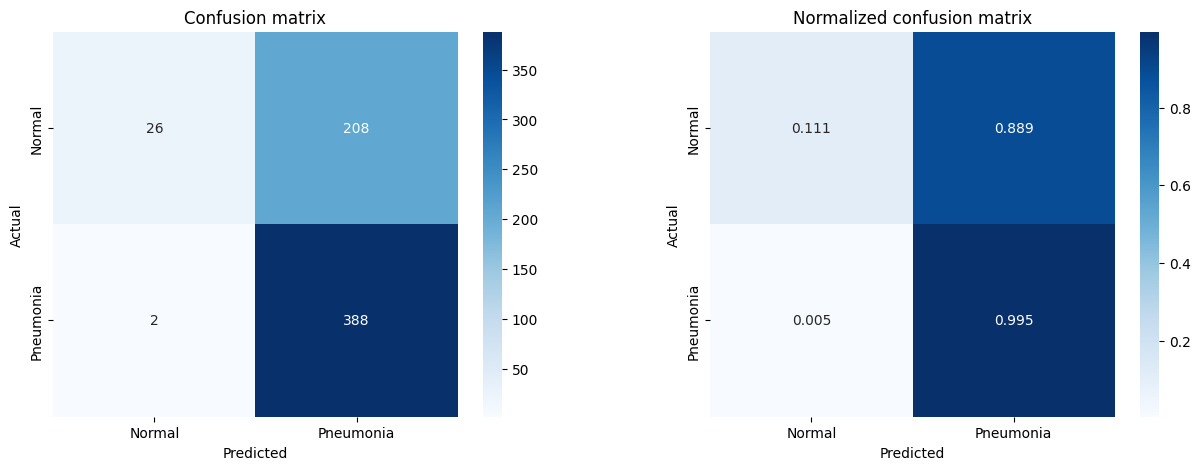

In [9]:
# Build the confusion matrix
cm = confusion_matrix(labels, preds)

# Normalize the confusion matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Ticklables
ticklabels = ['Normal', 'Pneumonia']

# Plot
fig, ax = plt.subplots(figsize=(15,5))

# Confusion matrix
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt='.3g', xticklabels=ticklabels, yticklabels=ticklabels, cmap=plt.cm.Blues);
plt.title('Confusion matrix');
plt.xlabel('Predicted');
plt.ylabel('Actual');

# Normalized confusion matrix
plt.subplot(1,2,2)
sns.heatmap(cmn, annot=True, fmt='.3f', xticklabels=ticklabels, yticklabels=ticklabels, cmap=plt.cm.Blues);
plt.title('Normalized confusion matrix');
plt.xlabel('Predicted');
plt.ylabel('Actual');

plt.subplots_adjust(wspace=.3)

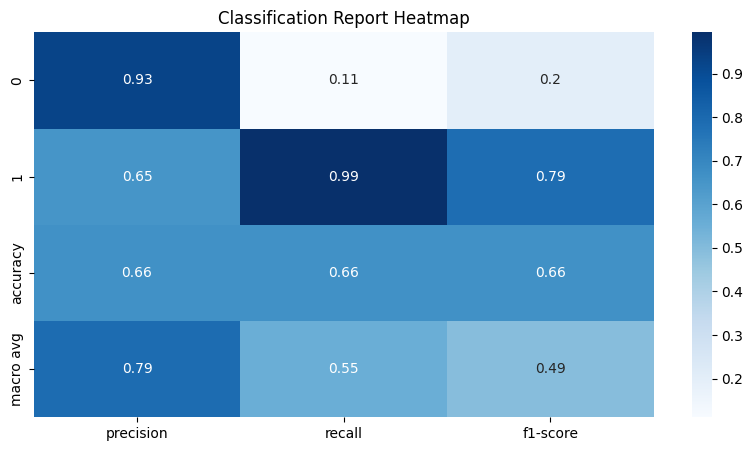

In [10]:
probs_array = np.array(probs)

# Classification report heatmap
report = classification_report(labels, preds, output_dict=True)
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(10, 5))
sns.heatmap(report_df.iloc[:-1, :].drop(columns='support'), annot=True, cmap="Blues")
plt.title("Classification Report Heatmap")
plt.show()

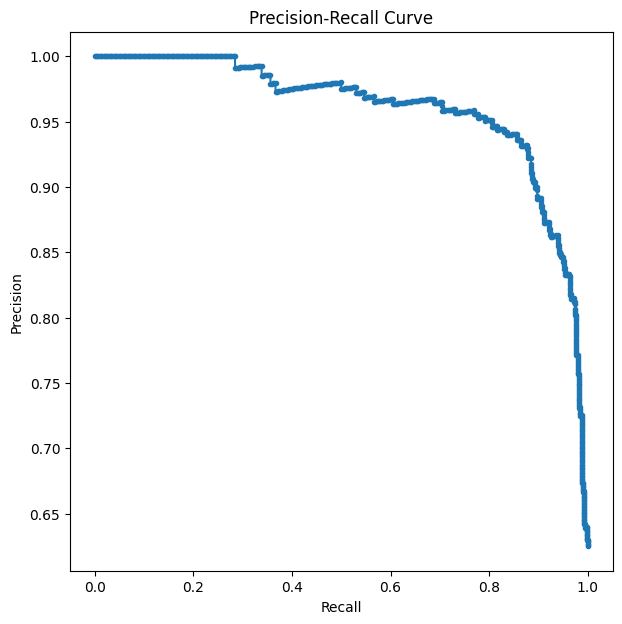

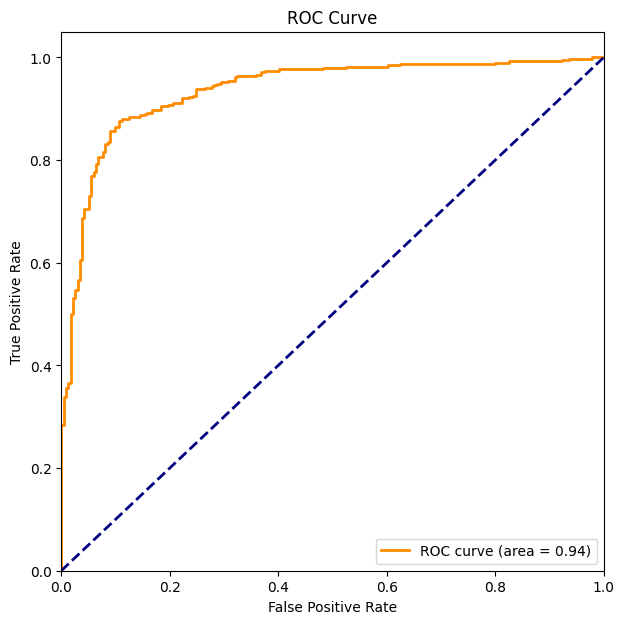

In [11]:
# PR Curve
precision, recall, _ = precision_recall_curve(labels, probs)
plt.figure(figsize=(7, 7))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


### Visualizing Training Time vs Batch Size for Different GPU Counts

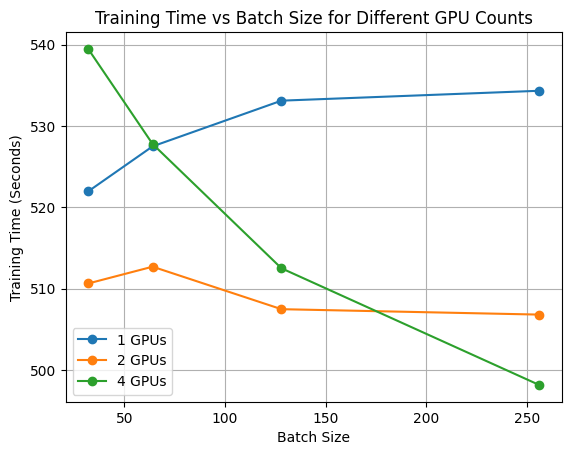

In [12]:
# Read the CSV file into a DataFrame
df = pd.read_csv('training_times.csv')

# Get unique GPU counts
gpu_counts = df['GPUs'].unique()

# Plot line graph for each GPU count
for gpu_count in gpu_counts:
    gpu_df = df[df['GPUs'] == gpu_count]
    plt.plot(gpu_df['Batch Size'], gpu_df['Training Time (Seconds)'], 'o-',
             label=f'{gpu_count} GPUs')

# Add labels and title
plt.xlabel('Batch Size')
plt.ylabel('Training Time (Seconds)')
plt.title('Training Time vs Batch Size for Different GPU Counts')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()